# Load dependences

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
import numpy as np
from rdkit.Chem import rdFMCS
from mlutils import standardxyz
from ase import Atoms
from ase.visualize import view

"Mol" object to match the substructures of ferrrocene and cyclopentadiene in ligand

In [2]:
ferr_mol = AllChem.AddHs(Chem.MolFromSmiles('C1([Fe]C2C=CC=C2)C=CC=C1'))
cpd_mol = AllChem.AddHs(Chem.MolFromSmiles('[Fe]C1C=CC=C1'))

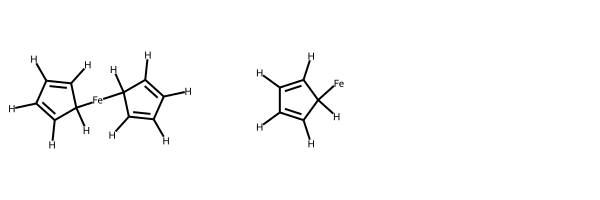

In [3]:
Draw.MolsToGridImage([ferr_mol,cpd_mol])

Generate 3D geometry of ferrocene with correct sterochemistry

In [14]:
smiles = 'CC(C)(C)[C@H]1COC(C2=C(P(c3ccccc3)c3ccccc3)[C@H]([Fe]C3C=CC=C3)C=C2)=N1'
mol = AllChem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
atoms = [tmp_atom for tmp_atom in mol.GetAtoms()]
atom_types = [tmp_atom.GetAtomicNum() for tmp_atom in atoms]
positions = mol.GetConformer().GetPositions()

RDKit ERROR: [02:53:51] UFFTYPER: Unrecognized atom type: Fe5 (24)


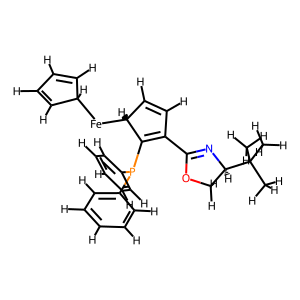

In [15]:
Draw.MolToImage(mol)

Find ferrocene and cyclopentadiene

In [16]:
ferr_res = rdFMCS.FindMCS([mol,ferr_mol],bondCompare=rdFMCS.BondCompare.CompareAny)
ferr_match_indices = mol.GetSubstructMatch(Chem.MolFromSmarts(ferr_res.smartsString))
cpd_res = rdFMCS.FindMCS([mol,cpd_mol])
cpd_match_indices = mol.GetSubstructMatch(Chem.MolFromSmarts(cpd_res.smartsString))
origin_atom_idx_to_delete = [item for item in cpd_match_indices]
sub_cpd_match_indices = list(set(ferr_match_indices)-set(cpd_match_indices))
Fe_index = mol.GetSubstructMatch(Chem.MolFromSmiles('[Fe]'))[0]
carbon_index_connect_Fe = [item.GetIdx() for item in atoms[Fe_index].GetNeighbors()]
key_index_1 = [item+1 for item in carbon_index_connect_Fe if item in sub_cpd_match_indices]
key_index_23 = [item.GetIdx()+1 for item in atoms[key_index_1[0]-1].GetNeighbors() if item.GetAtomicNum() == 6]
key_index_123 = key_index_1 + key_index_23
## use “standardxyz” function to rotate the molecule to fix one of the cpd in ferrocene at YZ plane
std_positions = standardxyz(positions,key_index_123[0],key_index_123[1],key_index_123[2])

Correct the 3D structure

In [17]:
if std_positions[Fe_index][0] > 0:
    ## 'Ferr_std.sdf' is a ferrocene structure file one cpd in this ferrocene is fixed at YZ plane
    ## the Fe atom and the other cpd is at the space of positive X-axis
    Ferr_mol = Chem.MolFromMolFile('./Ferr/Ferr_std.sdf',removeHs=False)
else:
    ## 'Ferr_std_reverse.sdf' is a ferrocene structure file one cpd in this ferrocene is fixed at YZ plane
    ## the Fe atom and the other cpd is at the space of negative X-axis
    Ferr_mol = Chem.MolFromMolFile('./Ferr/Ferr_std_reverse.sdf',removeHs=False)
Ferr_atoms = [tmp_atom for tmp_atom in Ferr_mol.GetAtoms()]
Ferr_atom_types = [tmp_atom.GetAtomicNum() for tmp_atom in Ferr_atoms]
Ferr_conf = Ferr_mol.GetConformer()
Ferr_positions = Ferr_conf.GetPositions()
Ferr_need_idx = [0,6,7,8,9,10,15,16,17,18,19]
Ferr_atom_types = [Ferr_atom_types[i] for i in Ferr_need_idx]
Ferr_positions = [Ferr_positions[i] for i in Ferr_need_idx]
atom_types = [atom_types[i] for i in range(len(atom_types)) if not i in origin_atom_idx_to_delete]
std_positions = [std_positions[i] for i in range(len(std_positions)) if not i in origin_atom_idx_to_delete]
new_atom_types = atom_types + Ferr_atom_types
new_std_positions = std_positions + Ferr_positions
atoms = Atoms(new_atom_types,new_std_positions)

Visualize the reasonable 3D geometry

In [18]:
view(atoms, viewer='x3d')